In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorcet as cc
from scipy.stats import linregress as lire
plt.style.use("seaborn")

# 0. Datos del DANE

Se importan datos del **DANE** de valor agregado.

In [2]:
df_pib=pd.read_excel("./dane/pib.xlsx",sheet_name="esta")
df_va=pd.read_excel("./dane/vagregado.xlsx",sheet_name="esta")
df_va.columns=['mpio_id','mpio','depto_id','depto',2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]
df_va.head()

,mpio_id,mpio,depto_id,depto,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,5001,Medellín,5,Antioquia,34442.533356,36924.720125,40880.873855,43042.337120,45551.404608,49047.761437,51394.011711,55082.301180,59434.240203,56911.343578
1,5002,Abejorral,5,Antioquia,127.175011,149.297199,148.804371,159.844908,172.950168,202.311691,234.833122,231.172055,244.494059,242.763952
2,5004,Abriaquí,5,Antioquia,17.549168,17.277452,17.646686,18.790072,18.197030,20.171697,21.674609,28.562662,31.816859,32.94684
3,5021,Alejandría,5,Antioquia,89.982678,34.581247,37.736771,39.952244,42.639327,46.560466,51.273272,52.334339,56.855260,57.620284
4,5030,Amagá,5,Antioquia,216.948524,262.574210,270.484607,315.780855,333.042072,358.089541,468.548773,492.098704,535.866833,534.652315


Se importan datos del **DANE** de número de viviendas y hogares.

In [3]:
df_hog1=pd.read_excel("./dane/hogar1.xlsx",sheet_name="esta")[1:]
df_hog2=pd.read_excel("./dane/hogar2.xlsx",sheet_name="esta")[1:]
df_viv1=pd.read_excel("./dane/vivi1.xlsx",sheet_name="esta")[1:]
df_viv2=pd.read_excel("./dane/vivi2.xlsx",sheet_name="esta")[1:]
df_viv=df_viv1.merge(df_viv2,on=["depto","mpio","tipo"],how='outer').fillna(0)
df_hog=df_hog1.merge(df_hog2,on=["depto","mpio","tipo"],how='outer').fillna(0)
del df_viv2,df_viv1,df_hog1,df_hog2

# 1. Análisis de mercado de internet
Lectura de datos de acceso a internet desde 2017:

In [4]:
prfx="https://raw.githubusercontent.com/caramirezs/DataJam2022/master/bases_datos/"
#prfx="./bases_datos/" #importación local
df_1 = pd.read_csv(prfx+'accesos_internet_fijo_desde20172T_p1.csv')
df_2 = pd.read_csv(prfx+'accesos_internet_fijo_desde20172T_p2.csv')
df_3 = pd.read_csv(prfx+'accesos_internet_fijo_desde20172T_p3.csv')
df_4 = pd.read_csv(prfx+'accesos_internet_fijo_desde20172T_p4.csv')
df_5 = pd.read_csv(prfx+'accesos_internet_fijo_desde20172T_p5.csv')
df_6 = pd.read_csv(prfx+'accesos_internet_fijo_desde20172T_p6.csv')
df = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6])
del df_1,df_2,df_3,df_4,df_5,df_6
df['datetime']=  df.apply(lambda row: f'{row.anno}/{str(row.trimestre).zfill(2)}', axis=1)

C:\Users\ACER\AppData\Local\Temp\ipykernel_12012\1346977021.py:5: DtypeWarning: Columns (10,11) have mixed types. Specify dtype option on import or set low_memory=False.
  df_3 = pd.read_csv(prfx+'accesos_internet_fijo_desde20172T_p3.csv')


In [5]:
df['mpiod']=df.apply(lambda row: f'{row.departamento}-{str(row.municipio).zfill(2)}', axis=1) #combinación depto-mpio porque hay nombres que se repiten
df.head()

,anno,trimestre,id_empresa,empresa,id_municipio,municipio,id_departamento,departamento,id_segmento,segmento,velocidad_efectiva_downstream,velocidad_efectiva_upstream,id_tecnologia,tecnologia,accesos,entry_id,datetime,mpiod
0,2017,2,900217277,SYSTEL COMUNICACIONES CARTAGO S.A.S.,76147,CARTAGO,76,VALLE DEL CAUCA,104,Residencial - Estrato 4,1,"0,5",114,Otras tecnologías inalámbricas,7,1,2017/02,VALLE DEL CAUCA-CARTAGO
1,2017,2,900217277,SYSTEL COMUNICACIONES CARTAGO S.A.S.,76147,CARTAGO,76,VALLE DEL CAUCA,101,Residencial - Estrato 1,2,1,114,Otras tecnologías inalámbricas,1,2,2017/02,VALLE DEL CAUCA-CARTAGO
2,2017,2,900217277,SYSTEL COMUNICACIONES CARTAGO S.A.S.,76147,CARTAGO,76,VALLE DEL CAUCA,107,Corporativo,"0,8","0,5",114,Otras tecnologías inalámbricas,1,3,2017/02,VALLE DEL CAUCA-CARTAGO
3,2017,2,900217277,SYSTEL COMUNICACIONES CARTAGO S.A.S.,76147,CARTAGO,76,VALLE DEL CAUCA,107,Corporativo,"2,8",2,114,Otras tecnologías inalámbricas,13,4,2017/02,VALLE DEL CAUCA-CARTAGO
4,2017,2,900217277,SYSTEL COMUNICACIONES CARTAGO S.A.S.,76147,CARTAGO,76,VALLE DEL CAUCA,104,Residencial - Estrato 4,"1,5","0,7",114,Otras tecnologías inalámbricas,2,5,2017/02,VALLE DEL CAUCA-CARTAGO


## 1.1. Elaboración de un diccionario que convierta código de municipios a nombre de municipio

Primero chequeamos que los códigos y los municipios coinciden en número:

In [7]:
mpiodl=list(df.mpiod.unique())
mpioidl=list(df.id_municipio.unique())
len(mpiodl),len(mpioidl)

(1122, 1122)

Ahora sí, hacemos diccionarios:

In [8]:
lsmpioid=[]
lsmpio=[]
for id in mpioidl:
    mn=list(df[df.id_municipio==id].mpiod)[0]
    lsmpio.append(mn)
    lsmpioid.append(id)
id_to_mpio=dict(zip(lsmpioid,lsmpio))
mpio_to_id=dict(zip(lsmpio,lsmpioid))

## 1.2. Generamos datos indicadores de crecimiento por municipio

Se escogen los datos esenciales.

In [9]:
tab=df.groupby(['datetime','id_municipio'],as_index=False)["accesos"].sum()
tab.head()

,datetime,id_municipio,accesos
0,2017/02,0,52
1,2017/02,5001,556657
2,2017/02,5002,940
3,2017/02,5004,68
4,2017/02,5021,293


Inicializamos un `DataFrame` nuevo con nombre de municipio y código.

In [10]:
dfmp=pd.DataFrame(lsmpio)
dfmp.columns=["mpio"]
dfmp["mpio_id"]=lsmpioid

Genereamos una clasificación de regiones.

In [11]:
deptol=list(df.departamento.unique())
regionl=['OCCIDENTE','BOYACÁ-SANTANDERES','OCCIDENTE','CUNDINAMARCA-OPITA','PAISA','CUNDINAMARCA-OPITA','ORINOQUÍA-AMAZONÍA','CARIBE-INSULAR','PAISA','OCCIDENTE','ORINOQUÍA-AMAZONÍA','ORINOQUÍA-AMAZONÍA','PAISA','ORINOQUÍA-AMAZONÍA','CARIBE-INSULAR','CARIBE-INSULAR','CUNDINAMARCA-OPITA','CARIBE-INSULAR','CARIBE-INSULAR','OCCIDENTE','BOYACÁ-SANTANDERES','BOYACÁ-SANTANDERES','CARIBE-INSULAR','CUNDINAMARCA-OPITA','CARIBE-INSULAR','ORINOQUÍA-AMAZONÍA','ORINOQUÍA-AMAZONÍA','CARIBE-INSULAR','ORINOQUÍA-AMAZONÍA','PAISA','ORINOQUÍA-AMAZONÍA','ORINOQUÍA-AMAZONÍA','ORINOQUÍA-AMAZONÍA',
 'INDETERMINADO']
depto_to_region=dict(zip(deptol,regionl)) #Conversión depto a región
dfmp["region"]=dfmp.mpio.apply(lambda x:depto_to_region[x.split('-')[0]])

Lista de fechas distintas:

In [12]:
dates=list(tab.datetime.unique())

Acá hacemos una regresión lineal de $a(t)=\beta_1 t +\beta_0$ donde $a$ es el número de accesos en el municipio y $t$ es el tiempo medido en trimestres. Solo se usan los últimos 5 trimestres para evaluar la tendencia más reciente. Se registra entonces la pendiente $\beta_1$ y el $r^2$ (*coeficiente de determinación*) de la regresión. El número en `meanacc` es el número de accesos promedio $\bar{a}$ en los últimos cinco trimestres.

In [13]:
slope=[]
r2=[]
meanacc=[]
npp=-5
for i in range(len(dfmp)):
    sub=tab[(tab.id_municipio==dfmp.iloc[i].mpio_id)]
    y=np.array(sub.accesos)
    slopeval,r2val=0,0
    if len(y)>5:
        y=y[npp:]
        x=np.arange(0,len(y),1)
        try:
            slopeval,kval,r2val,p,se=lire(x,y)
        except:
            slopeval,kval,r2val,p,se=0,0,0,0,0
    slope.append(slopeval)
    r2.append(r2val**2)
    meanacc.append(y.mean())
dfmp["slope"]=slope
dfmp["r2"]=r2
dfmp["meanacc"]=meanacc
dfmp.head()


,mpio,mpio_id,region,slope,r2,meanacc
0,VALLE DEL CAUCA-CARTAGO,76147,OCCIDENTE,-185.0,0.268596,24150.2
1,VALLE DEL CAUCA-ANSERMANUEVO,76041,OCCIDENTE,53.7,0.925886,1721.6
2,VALLE DEL CAUCA-LA UNIÓN,76400,OCCIDENTE,110.6,0.912857,4766.8
3,VALLE DEL CAUCA-TORO,76823,OCCIDENTE,-10.6,0.298893,1450.6
4,BOYACÁ-VILLA DE LEYVA,15407,BOYACÁ-SANTANDERES,469.3,0.821576,2290.2


Gráfica simple para ver como evolucionan temporalmente los accesos en un municipio (Bogotá en este caso):

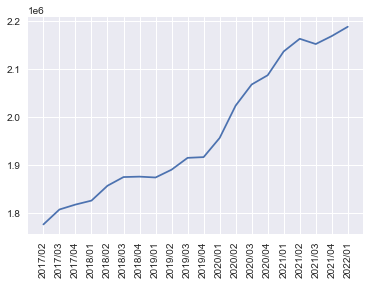

In [21]:
sub=tab[(tab.id_municipio==11001)]
y=np.array(sub.accesos)
plt.plot(dates,y)
plt.xticks(rotation=90)
plt.show()

In [24]:
df_va

,mpio_id,mpio,depto_id,depto,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,5001,Medellín,5,Antioquia,34442.533356,36924.720125,40880.873855,43042.337120,45551.404608,49047.761437,51394.011711,55082.301180,59434.240203,56911.343578
1,5002,Abejorral,5,Antioquia,127.175011,149.297199,148.804371,159.844908,172.950168,202.311691,234.833122,231.172055,244.494059,242.763952
2,5004,Abriaquí,5,Antioquia,17.549168,17.277452,17.646686,18.790072,18.197030,20.171697,21.674609,28.562662,31.816859,32.94684
3,5021,Alejandría,5,Antioquia,89.982678,34.581247,37.736771,39.952244,42.639327,46.560466,51.273272,52.334339,56.855260,57.620284
4,5030,Amagá,5,Antioquia,216.948524,262.574210,270.484607,315.780855,333.042072,358.089541,468.548773,492.098704,535.866833,534.652315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,97889,Yavaraté,97,Vaupés,2.636453,2.739143,3.039200,3.140278,3.049669,3.505832,3.462723,3.718033,3.544544,3.27756
1118,99001,Puerto Carreño,99,Vichada,102.404040,96.239519,106.433902,99.837684,119.353457,118.534909,124.314056,128.940993,136.520506,134.46378
1119,99524,La Primavera,99,Vichada,61.759855,75.468876,78.545525,76.266606,82.320867,86.343073,95.907599,170.961044,196.688120,177.898527
1120,99624,Santa Rosalía,99,Vichada,26.952429,28.747679,40.306389,41.695511,38.276063,37.164697,48.693458,43.862214,59.194904,75.323267


Ahora se hace un análisis de $v(t)=\alpha_1 t +\alpha_0$ con $v$ el valor agregado del municipio (muy similar al caso de accesos). La pendiente ahora es en (valor agregado por año) y se usa la ventana de tiempo desde 2014 hasta 2019 (no se usa 2020 por crisis de COVID). Se halla también el promedio $\bar{v}$.

In [25]:
slope=[]
r2=[]
meanacc=[]
for i in range(len(dfmp)):
    sub=df_va[df_va.mpio_id==dfmp.iloc[i].mpio_id]
    y=np.array(sub.iloc[:,-6:-1])
    y=list(y.flatten())
    x=np.arange(0,len(y),1)
    try:
        slopeval,kval,r2val,p,se=lire(x,y)
    except:
        slopeval,kval,r2val,p,se=0,0,0,0,0
    slope.append(slopeval)
    r2.append(r2val**2)
    meanacc.append(np.array(y).mean())
dfmp["vaslope"]=slope
dfmp["var2"]=r2
dfmp["meanva"]=meanacc
dfmp.head()


C:\Users\ACER\AppData\Local\Temp\ipykernel_12012\381757810.py:15: RuntimeWarning: Mean of empty slice.
  meanacc.append(np.array(y).mean())
C:\Users\ACER\anaconda3\envs\geo_env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,mpio,mpio_id,region,slope,r2,meanacc,vaslope,var2,meanva
0,VALLE DEL CAUCA-CARTAGO,76147,OCCIDENTE,-185.0,0.268596,24150.2,147.793231,0.982762,2133.956381
1,VALLE DEL CAUCA-ANSERMANUEVO,76041,OCCIDENTE,53.7,0.925886,1721.6,17.339885,0.884470,266.292715
2,VALLE DEL CAUCA-LA UNIÓN,76400,OCCIDENTE,110.6,0.912857,4766.8,41.177764,0.968678,425.604558
3,VALLE DEL CAUCA-TORO,76823,OCCIDENTE,-10.6,0.298893,1450.6,10.614483,0.904276,174.241511
4,BOYACÁ-VILLA DE LEYVA,15407,BOYACÁ-SANTANDERES,469.3,0.821576,2290.2,41.950319,0.577419,275.577923


Para graficar se comienza con una base de datos más limpia.

In [239]:
dfmpc=dfmp.dropna()
dfmpc=dfmpc[dfmpc.r2>0.3] # Se quitan r2 muy bajos
dfmpc=dfmpc[dfmpc.var2>0.3] # Se quitan var2 muy bajos
dfmpc.head()

,mpio,mpio_id,region,slope,r2,meanacc,vaslope,var2,meanva,nviv,nva,purb,slopetv,r2tv,meansuscptv
1,VALLE DEL CAUCA-ANSERMANUEVO,76041,OCCIDENTE,53.7,0.925886,1721.6,17.339885,0.884470,266.292715,8401.0,311.612289,0.460183,-2.966522,0.680586,402.208333
2,VALLE DEL CAUCA-LA UNIÓN,76400,OCCIDENTE,110.6,0.912857,4766.8,41.177764,0.968678,425.604558,12210.0,516.522096,0.789353,-6.335652,0.613426,856.500000
4,BOYACÁ-VILLA DE LEYVA,15407,BOYACÁ-SANTANDERES,469.3,0.821576,2290.2,41.950319,0.577419,275.577923,8513.0,427.654163,0.386468,-25.056957,0.635562,2557.208333
5,VALLE DEL CAUCA-DAGUA,76233,OCCIDENTE,-546.7,0.361405,5592.8,83.474650,0.921073,700.281160,24433.0,902.320956,0.166537,-42.095217,0.741645,4523.708333
6,CAUCA-EL TAMBO,19256,OCCIDENTE,247.1,0.786121,4992.2,38.476757,0.958756,462.729824,21276.0,538.235135,0.055227,-17.385652,0.259344,638.041667


Librería gráfica y lista de regiones.

In [40]:
import plotly.express as px
from plotly.graph_objects import Layout
regl=list(dfmpc.region.unique()) # lista de regiones


Estas gráficas de $\beta_1(\alpha_1)$ ofrecen patrones interesantes de asociación para cada región. El tamaño de los marcadores es proporcional a $\sqrt{\bar{a}}$ (medida del tamaño del mercado). El color es proporcional a $r^2$ de la pendiente de $\beta_1$. Esto último quiere decir que los puntos más amarillos ofrecen un patrón estadísticamente más certero.

In [151]:
regg=regl[5]
rx=[-160,150]
ry=[-300,300]
# rx=None
# ry=None
fig = px.scatter(dfmpc[dfmpc.region==regg], x="vaslope", y="slope",size="meanacc", color="r2",hover_name="mpio",size_max=50,width=800,height=700,labels={"vaslope": "Crecimiento de valor agregado (M$/año)","slope": "Crecimiento de internet (accesos/trimestre)"},opacity=0.6,trendline='ols',title=regg,template='plotly',range_y=ry,range_x=rx)

fig.show()

Guardamos las imágenes con zoom o sin zoom.

In [152]:
fig.write_image("grafs/internet_crecimiento_crecva_"+regg+"zoom.png")

# 1.3. Crecimiento de mercado vs. ruralidad y valor agregado por vivienda

Ahora generaremos un unos indicadores extra de cada municipio basados en el año 2009. El primer indicador al que le queremos apuntas es valor agregado por número de viviendas. Este es un indicador similar al PIB per cápita que indica la relevancia económica ponderada respecto al número de viviendas. El segundo indicador es el porcentaje de la población que vive en el casco urbano del municipio, lo cual revela un nivel de urbanización. Veremos cómo estos indicadores se relacionan con $\beta_1$ (crecimiento del mercado).

In [154]:
df_viv.head()

,depto_id_x,depto,mpio_id_x,mpio,tipo,2005,2006,2007,2008,2009,...,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035
0,5.0,Antioquia,5001.0,Medellín,Total,556418.0,572828.0,591044.0,611241.0,633260.0,...,1159832.0,1196061.0,1231192.0,1264978.0,1297160.0,1328247.0,1358721.0,1388597.0,1417922.0,1446673.0
1,5.0,Antioquia,5001.0,Medellín,Cabecera,542757.0,558952.0,576799.0,596467.0,617762.0,...,1137602.0,1173345.0,1208006.0,1241247.0,1272877.0,1303396.0,1333299.0,1362584.0,1391333.0,1419490.0
2,5.0,Antioquia,5001.0,Medellín,Centros Poblados y Rural Disperso,13661.0,13876.0,14245.0,14774.0,15498.0,...,22230.0,22716.0,23186.0,23731.0,24283.0,24851.0,25422.0,26013.0,26589.0,27183.0
3,5.0,Antioquia,5002.0,Abejorral,Total,7175.0,7252.0,7368.0,7511.0,7710.0,...,11256.0,11543.0,11833.0,12133.0,12421.0,12711.0,13002.0,13300.0,13597.0,13868.0
4,5.0,Antioquia,5002.0,Abejorral,Cabecera,2186.0,2229.0,2288.0,2352.0,2433.0,...,4901.0,5056.0,5200.0,5344.0,5477.0,5607.0,5738.0,5866.0,5987.0,6101.0


In [156]:
subtab=df_viv.loc[:,["mpio_id_x","tipo","2019"]]

In [157]:
nviv=[]
purb=[]
nva=[]
for i in range(len(dfmp)):
    mpid=dfmp.iloc[i].mpio_id
    sub1=df_va[df_va.mpio_id==mpid]
    sub2=subtab[subtab.mpio_id_x==mpid]
    n1=len(sub1)
    n2=len(sub2)
    total,cab,rural,va=0,0,0,0
    purbval=0
    if n2>0:
        total=float(sub2[sub2.tipo=="Total"]["2019"])
        cab=float(sub2[sub2.tipo=="Cabecera"]["2019"])
    if n1==1:
        va=float(sub1.loc[:,2019])
    if total!=0: purbval=cab/total
    nviv.append(total)
    nva.append(va)
    purb.append(purbval)
dfmp["nviv"]=nviv
dfmp["nva"]=nva
dfmp["purb"]=purb
dfmp.head()

,mpio,mpio_id,region,slope,r2,meanacc,vaslope,var2,meanva,nviv,nva,purb
0,VALLE DEL CAUCA-CARTAGO,76147,OCCIDENTE,-185.0,0.268596,24150.2,147.793231,0.982762,2133.956381,48543.0,2436.448012,0.962672
1,VALLE DEL CAUCA-ANSERMANUEVO,76041,OCCIDENTE,53.7,0.925886,1721.6,17.339885,0.884470,266.292715,8401.0,311.612289,0.460183
2,VALLE DEL CAUCA-LA UNIÓN,76400,OCCIDENTE,110.6,0.912857,4766.8,41.177764,0.968678,425.604558,12210.0,516.522096,0.789353
3,VALLE DEL CAUCA-TORO,76823,OCCIDENTE,-10.6,0.298893,1450.6,10.614483,0.904276,174.241511,5937.0,190.721694,0.595250
4,BOYACÁ-VILLA DE LEYVA,15407,BOYACÁ-SANTANDERES,469.3,0.821576,2290.2,41.950319,0.577419,275.577923,8513.0,427.654163,0.386468


In [158]:
dfmpc=dfmp.dropna()
#dfmpc["meanacc_sc"]=np.array(dfmpc.meanacc)**0.5 # Una reescalada del acceso por si se quieren hacer burbujas menos diferentes en tamaño
dfmpc=dfmpc[dfmpc.r2>0.3] # solo r2 importantes
# dfmpc["slope_nviv"]=dfmpc.loc[:,"slope"]/dfmpc.loc[:,"nviv"]
# dfmpc["slopeva_nviv"]=dfmpc.loc[:,"vaslope"]/dfmpc.loc[:,"nviv"]
dfmpc["vapc"]=dfmpc.apply(lambda row: row.nva/row.nviv,axis=1)
# dfmpc["relslope"]=dfmpc.loc[:,"slope"]/dfmpc.loc[:,"meanacc"]
dfmpc.head()

,mpio,mpio_id,region,slope,r2,meanacc,vaslope,var2,meanva,nviv,nva,purb,vapc
1,VALLE DEL CAUCA-ANSERMANUEVO,76041,OCCIDENTE,53.7,0.925886,1721.6,17.339885,0.884470,266.292715,8401.0,311.612289,0.460183,0.037092
2,VALLE DEL CAUCA-LA UNIÓN,76400,OCCIDENTE,110.6,0.912857,4766.8,41.177764,0.968678,425.604558,12210.0,516.522096,0.789353,0.042303
4,BOYACÁ-VILLA DE LEYVA,15407,BOYACÁ-SANTANDERES,469.3,0.821576,2290.2,41.950319,0.577419,275.577923,8513.0,427.654163,0.386468,0.050235
5,VALLE DEL CAUCA-DAGUA,76233,OCCIDENTE,-546.7,0.361405,5592.8,83.474650,0.921073,700.281160,24433.0,902.320956,0.166537,0.036930
6,CAUCA-EL TAMBO,19256,OCCIDENTE,247.1,0.786121,4992.2,38.476757,0.958756,462.729824,21276.0,538.235135,0.055227,0.025298


Primero miramos dependencia del crecimiento respecto al valor agregado por vivienda.

In [178]:
fig=px.scatter(dfmpc, x="vapc", y="slope",size="meanacc",hover_name="mpio",color="r2",size_max=80,opacity=0.6,log_x=True,log_y=False,width=800,height=600,template="plotly",labels={"slope": "Crecimiento de internet (accesos/trimestre)","vapc": "Valor agregado por vivienda (M$/viv)"})

fig.show()
fig.write_image("grafs/internet_crecimiento_vagrperviv.png")

In [181]:
fig=px.scatter(dfmpc, x="purb", y="slope",size="meanacc",hover_name="mpio",color="r2",size_max=80,opacity=0.6,log_x=False,log_y=False,width=800,height=800,labels={"purb": "Porcentaje de urbanización","slope": "Crecimiento de mercado (Accesos/Trimestre)"},template="plotly")

fig.show()
fig.write_image("grafs/internet_crecimiento_porceurb.png")

# 2. Mercado de televisión fija

Ahora haremos un análisis similar para la televisión fija. Primero se importan los datos.

In [182]:
prfx="https://raw.githubusercontent.com/caramirezs/DataJam2022/master/bases_datos/"
#prfx="./bases_datos/" #importación local
df_1 = pd.read_csv(prfx+'suscriptores_tv_p1.csv', low_memory=False)
df_2 = pd.read_csv(prfx+'suscriptores_tv_p2.csv', low_memory=False)
dftv= pd.concat([df_1,df_2])
del df_1,df_2

In [186]:
dftv['datetime']=  dftv.apply(lambda row: f'{row.anno}/{str(row.mes + 3*(row.trimestre-1)).zfill(2)}', axis=1)
dftv.head()

,anno,trimestre,mes,tipo_operador,id_operador,operador,id_departamento,departamento,id_municipio,municipio,esal,suscriptores,segmento,desc_segmento,tipo_tecnologia,des_tipo_tecnologia_television,entry_id,datetime
0,2010,1,1,MUNICIPALES,800075305,INGENIERIA EN POTENCIA ELECTRICA Y COMUNICACIO...,54,NORTE DE SANTANDER,54498,OCAÑA,0,2021,0,NaN,0,NaN,1,2010/01
1,2010,1,1,MUNICIPALES,800096566,CENTRO ELECTRONICO SERVI-AUTO RADIO SAR Y COMP...,99999,NaN,99999,NaN,0,0,0,NaN,0,NaN,2,2010/01
2,2010,1,1,MUNICIPALES,800111243,ALPEVISION S.A.,41,HUILA,41001,NEIVA,0,0,0,NaN,0,NaN,3,2010/01
3,2010,1,1,MUNICIPALES,800132211,H V TELEVISION S.A.S.,25,CUNDINAMARCA,25754,SOACHA,0,18928,0,NaN,0,NaN,4,2010/01
4,2010,1,1,MUNICIPALES,800179562,LEGON TELECOMUNICACIONES S.A.S.,5,ANTIOQUIA,5154,CAUCASIA,0,369,0,NaN,0,NaN,5,2010/01


Extraemos en cada municipio extraeoms suscriptores como función del tiempo.

In [257]:
tab=dftv.groupby(['datetime','id_municipio','anno'],as_index=False)["suscriptores"].sum()
tab.head()

,datetime,id_municipio,anno,suscriptores
0,2010/01,5088,2010,35995
1,2010/01,5154,2010,1748
2,2010/01,5250,2010,1158
3,2010/01,8573,2010,91
4,2010/01,8758,2010,7338


Nos concentramos solo en datos de 2017 en adelante.

In [258]:
tab.anno=tab.anno.astype(int)
tab=tab[tab.anno>=2017]
dates=list(tab.datetime.unique())
dates

['2017/01',
 '2017/02',
 '2017/03',
 '2017/04',
 '2017/05',
 '2017/06',
 '2017/07',
 '2017/08',
 '2017/09',
 '2017/10',
 '2017/11',
 '2017/12',
 '2018/01',
 '2018/02',
 '2018/03',
 '2018/04',
 '2018/05',
 '2018/06',
 '2018/07',
 '2018/08',
 '2018/09',
 '2018/10',
 '2018/11',
 '2018/12',
 '2019/01',
 '2019/02',
 '2019/03',
 '2019/04',
 '2019/05',
 '2019/06',
 '2019/07',
 '2019/08',
 '2019/09',
 '2019/10',
 '2019/11',
 '2019/12',
 '2020/01',
 '2020/02',
 '2020/03',
 '2020/04',
 '2020/05',
 '2020/06',
 '2020/07',
 '2020/08',
 '2020/09',
 '2020/10',
 '2020/11',
 '2020/12',
 '2021/01',
 '2021/02',
 '2021/03',
 '2021/04',
 '2021/05',
 '2021/06',
 '2021/07',
 '2021/08',
 '2021/09',
 '2021/10',
 '2021/11',
 '2021/12',
 '2022/01',
 '2022/02',
 '2022/03']

Exploramos la gráfica de evolución para Bogotá.

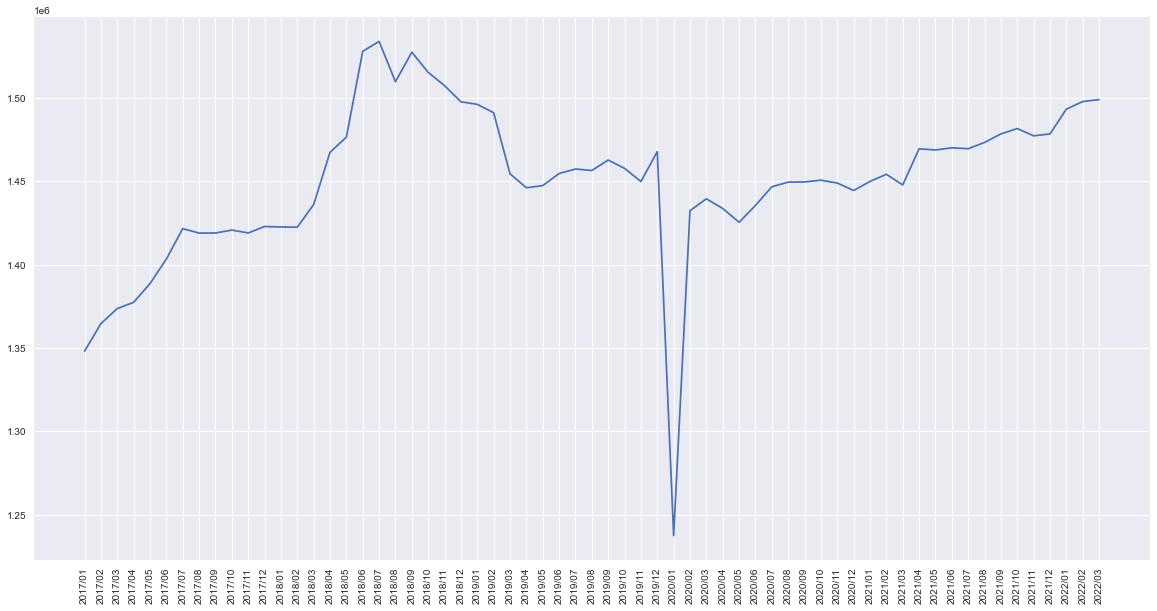

In [221]:
sub=tab[(tab.id_municipio==11001)]
plt.figure(figsize=(20,10))
y=np.array(sub.suscriptores)
plt.plot(dates,y)
plt.xticks(rotation=90)
plt.show()

Parece que la tendencia más o menos lineal podría ser a partir de 2020/08.

In [232]:
dates[-24:]

['2020/04',
 '2020/05',
 '2020/06',
 '2020/07',
 '2020/08',
 '2020/09',
 '2020/10',
 '2020/11',
 '2020/12',
 '2021/01',
 '2021/02',
 '2021/03',
 '2021/04',
 '2021/05',
 '2021/06',
 '2021/07',
 '2021/08',
 '2021/09',
 '2021/10',
 '2021/11',
 '2021/12',
 '2022/01',
 '2022/02',
 '2022/03']

In [259]:
slope=[]
r2=[]
meanacc=[]
npp=-24
for i in range(len(dfmp)):
    sub=tab[(tab.id_municipio==dfmp.iloc[i].mpio_id)]
    y=np.array(sub.suscriptores)
    slopeval,r2val=0,0
    if len(y)>5:
        y=y[npp:]
        x=np.arange(0,len(y),1)
        try:
            slopeval,kval,r2val,p,se=lire(x,y)
        except:
            slopeval,kval,r2val,p,se=0,0,0,0,0
    slope.append(slopeval)
    r2.append(r2val**2)
    meanacc.append(y.mean())
dfmp["slopetv"]=slope
dfmp["r2tv"]=r2
dfmp["meansuscptv"]=meanacc
dfmp.head()

C:\Users\ACER\AppData\Local\Temp\ipykernel_12012\241886910.py:18: RuntimeWarning:

Mean of empty slice.

C:\Users\ACER\anaconda3\envs\geo_env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars



,mpio,mpio_id,region,slope,r2,meanacc,vaslope,var2,meanva,nviv,nva,purb,slopetv,r2tv,meansuscptv
0,VALLE DEL CAUCA-CARTAGO,76147,OCCIDENTE,-185.0,0.268596,24150.2,147.793231,0.982762,2133.956381,48543.0,2436.448012,0.962672,160.524348,0.183424,16291.500000
1,VALLE DEL CAUCA-ANSERMANUEVO,76041,OCCIDENTE,53.7,0.925886,1721.6,17.339885,0.884470,266.292715,8401.0,311.612289,0.460183,-2.966522,0.680586,402.208333
2,VALLE DEL CAUCA-LA UNIÓN,76400,OCCIDENTE,110.6,0.912857,4766.8,41.177764,0.968678,425.604558,12210.0,516.522096,0.789353,-6.335652,0.613426,856.500000
3,VALLE DEL CAUCA-TORO,76823,OCCIDENTE,-10.6,0.298893,1450.6,10.614483,0.904276,174.241511,5937.0,190.721694,0.595250,5.263913,0.634549,436.958333
4,BOYACÁ-VILLA DE LEYVA,15407,BOYACÁ-SANTANDERES,469.3,0.821576,2290.2,41.950319,0.577419,275.577923,8513.0,427.654163,0.386468,-25.056957,0.635562,2557.208333


In [263]:
dfmpc=dfmp.loc[:,["mpio","mpio_id","region","vaslope","var2","nviv","nva","purb","slopetv","r2tv","meansuscptv"]].dropna()
#dfmpc["meanacc_sc"]=np.array(dfmpc.meanacc)**0.5 # Una reescalada del acceso por si se quieren hacer burbujas menos diferentes en tamaño
dfmpc=dfmpc[dfmpc.r2tv>0.3] # solo r2 importantes
dfmpc=dfmpc[dfmpc.var2>0.3] # Se quitan var2 muy bajos
dfmpc["vapc"]=dfmpc.apply(lambda row: row.nva/row.nviv,axis=1)
dfmpc.head()

,mpio,mpio_id,region,vaslope,var2,nviv,nva,purb,slopetv,r2tv,meansuscptv,vapc
1,VALLE DEL CAUCA-ANSERMANUEVO,76041,OCCIDENTE,17.339885,0.884470,8401.0,311.612289,0.460183,-2.966522,0.680586,402.208333,0.037092
2,VALLE DEL CAUCA-LA UNIÓN,76400,OCCIDENTE,41.177764,0.968678,12210.0,516.522096,0.789353,-6.335652,0.613426,856.500000,0.042303
3,VALLE DEL CAUCA-TORO,76823,OCCIDENTE,10.614483,0.904276,5937.0,190.721694,0.595250,5.263913,0.634549,436.958333,0.032124
4,BOYACÁ-VILLA DE LEYVA,15407,BOYACÁ-SANTANDERES,41.950319,0.577419,8513.0,427.654163,0.386468,-25.056957,0.635562,2557.208333,0.050235
5,VALLE DEL CAUCA-DAGUA,76233,OCCIDENTE,83.474650,0.921073,24433.0,902.320956,0.166537,-42.095217,0.741645,4523.708333,0.036930


In [262]:
rx=None
ry=None
regg=regl[1]
fig = px.scatter(dfmpc[dfmpc.region==regg], x="vaslope", y="slopetv",size="meansuscptv", color="r2tv",hover_name="mpio",size_max=50,width=800,height=700,labels={"vaslope": "Crecimiento de valor agregado (M$/año)","slopetv": "Crecimiento de TV fija (subscriptores/mes)"},opacity=0.6,trendline='ols',title=regg,template='plotly',range_y=ry,range_x=rx)
fig.show()

In [243]:
for regg in regionl:
    rx=None
    ry=None
    fig = px.scatter(dfmpc[dfmpc.region==regg], x="vaslope", y="slopetv",size="meansuscptv", color="r2tv",hover_name="mpio",size_max=50,width=800,height=700,labels={"vaslope": "Crecimiento de valor agregado (M$/año)","slopetv": "Crecimiento de TV fija (subscriptores/mes)"},opacity=0.6,trendline='ols',title=regg,template='plotly',range_y=ry,range_x=rx)
    fig.write_image("grafs/TV_crecimiento_crecva_"+regg+".png")


In [244]:
for regg in regionl:
    rx=[-100,500]
    ry=[-500,500]
    fig = px.scatter(dfmpc[dfmpc.region==regg], x="vaslope", y="slopetv",size="meansuscptv", color="r2tv",hover_name="mpio",size_max=50,width=800,height=700,labels={"vaslope": "Crecimiento de valor agregado (M$/año)","slopetv": "Crecimiento de TV fija (subscriptores/mes)"},opacity=0.6,trendline='ols',title=regg,template='plotly',range_y=ry,range_x=rx)
    fig.write_image("grafs/TV_crecimiento_crecva_"+regg+"zoom.png")

In [247]:
fig=px.scatter(dfmpc, x="vapc", y="slopetv",size="meansuscptv",hover_name="mpio",color="r2tv",size_max=80,opacity=0.6,log_x=True,log_y=False,width=800,height=600,template="plotly",labels={"slopetv": "Crecimiento de TV fija (suscriptores/mes)","vapc": "Valor agregado por vivienda (M$/viv)"})

fig.show()
fig.write_image("grafs/TV_crecimiento_vagrperviv.png")

In [265]:
fig=px.scatter(dfmpc, x="purb", y="slopetv",size="meansuscptv",hover_name="mpio",color="r2tv",size_max=80,opacity=0.6,log_x=False,log_y=False,width=800,height=800,labels={"purb": "Porcentaje de urbanización","slopetv": "Crecimiento de mercado de TV (suscriptores/mes)"},template="plotly")

fig.show()
fig.write_image("grafs/TV_crecimiento_porceurb.png")

# 3. Mercado de telefonía fija

Ahora haremos un análisis similar para la telefonía fija. Primero se importan los datos.

In [267]:
dirsuscp="https://raw.githubusercontent.com/caramirezs/DataJam2022/master/bases_datos/telefonia_local_p1.csv"
#dirsuscp="/bases_datos/telefonia_local_p1.csv" # para importación local
dftel=pd.read_csv(dirsuscp,low_memory=False)
dftel['datetime']=  tab.apply(lambda row: f'{row.anno}/{str(row.trimestre).zfill(2)}', axis=1)

In [268]:
dftel.head()

,anno,trimestre,id_empresa,empresa,id_departamento,departamento,id_municipio,municipio,id_ubicacion,ubicacion,id_segmento,segmento,lineas,entry_id,datetime
0,2012,1,800135729,ERT SA ESP,76.0,VALLE DEL CAUCA,76001,CALI,2,Urbano,1072,Comercial,938,1,2012/01
1,2012,1,800135729,ERT SA ESP,76.0,VALLE DEL CAUCA,76001,CALI,2,Urbano,1073,Oficial,603,2,2012/01
2,2012,1,800135729,ERT SA ESP,76.0,VALLE DEL CAUCA,76109,BUENAVENTURA,2,Urbano,101,Residencial - Estrato 1,283,3,2012/01
3,2012,1,800135729,ERT SA ESP,76.0,VALLE DEL CAUCA,76109,BUENAVENTURA,2,Urbano,102,Residencial - Estrato 2,636,4,2012/01
4,2012,1,800135729,ERT SA ESP,76.0,VALLE DEL CAUCA,76109,BUENAVENTURA,2,Urbano,103,Residencial - Estrato 3,743,5,2012/01


Subdatos de municipio y lineas por fecha.

In [270]:
tab=dftel.groupby(['datetime','id_municipio','anno'],as_index=False)["lineas"].sum()
tab.head()

,datetime,id_municipio,anno,lineas
0,2012/01,5001,2012,909631
1,2012/01,5002,2012,1503
2,2012/01,5004,2012,92
3,2012/01,5021,2012,287
4,2012/01,5030,2012,3534


Datos a partir de 2017.

In [271]:
tab.anno=tab.anno.astype(int)
tab=tab[tab.anno>=2017]
dates=list(tab.datetime.unique())
dates

['2017/01',
 '2017/02',
 '2017/03',
 '2017/04',
 '2018/01',
 '2018/02',
 '2018/03',
 '2018/04',
 '2019/01',
 '2019/02',
 '2019/03',
 '2019/04',
 '2020/01',
 '2020/02',
 '2020/03',
 '2020/04',
 '2021/01',
 '2021/02',
 '2021/03',
 '2021/04',
 '2022/01']

Los datos de 2020/01 parecen estar incompletos y la tendencia podría ser a partir de 2020/01 hasta 2021/04.

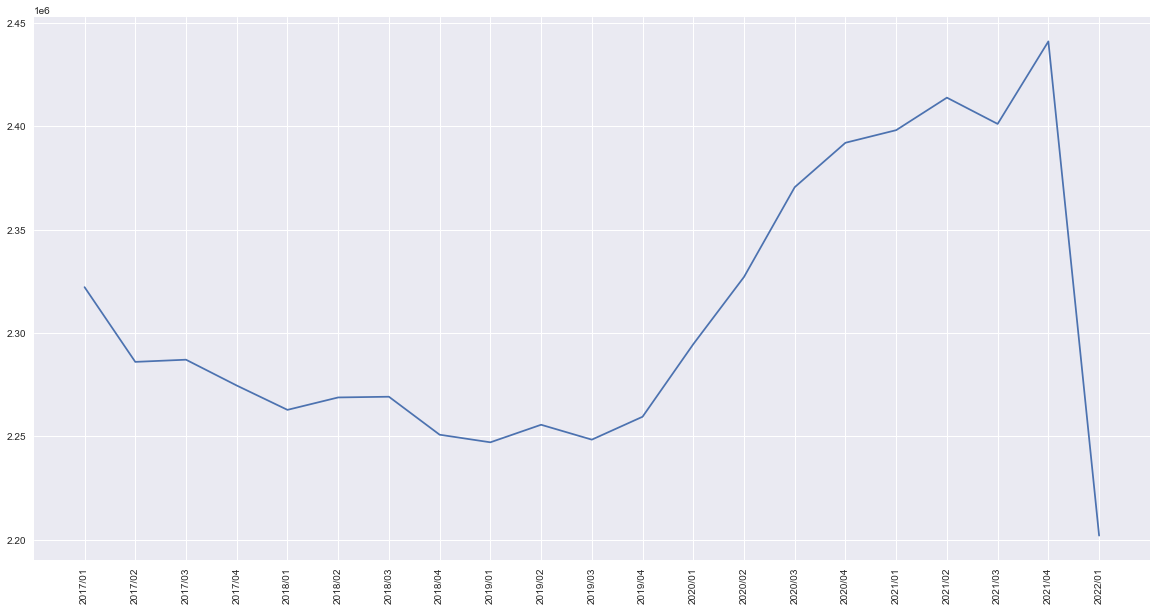

In [272]:
sub=tab[(tab.id_municipio==11001)]
plt.figure(figsize=(20,10))
y=np.array(sub.lineas)
plt.plot(dates,y)
plt.xticks(rotation=90)
plt.show()

In [276]:
dates[-9:-1]

['2020/01',
 '2020/02',
 '2020/03',
 '2020/04',
 '2021/01',
 '2021/02',
 '2021/03',
 '2021/04']

In [277]:
slope=[]
r2=[]
meanacc=[]
npp=-9
for i in range(len(dfmp)):
    sub=tab[(tab.id_municipio==dfmp.iloc[i].mpio_id)]
    y=np.array(sub.lineas)
    slopeval,r2val=0,0
    if len(y)>5:
        y=y[npp:-1]
        x=np.arange(0,len(y),1)
        try:
            slopeval,kval,r2val,p,se=lire(x,y)
        except:
            slopeval,kval,r2val,p,se=0,0,0,0,0
    slope.append(slopeval)
    r2.append(r2val**2)
    meanacc.append(y.mean())
dfmp["slopetel"]=slope
dfmp["r2tel"]=r2
dfmp["meanlines"]=meanacc
dfmp.head()

C:\Users\ACER\AppData\Local\Temp\ipykernel_12012\834998447.py:18: RuntimeWarning:

Mean of empty slice.

C:\Users\ACER\anaconda3\envs\geo_env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning:

invalid value encountered in double_scalars



,mpio,mpio_id,region,slope,r2,meanacc,vaslope,var2,meanva,nviv,nva,purb,slopetv,r2tv,meansuscptv,slopetel,r2tel,meanlines
0,VALLE DEL CAUCA-CARTAGO,76147,OCCIDENTE,-185.0,0.268596,24150.2,147.793231,0.982762,2133.956381,48543.0,2436.448012,0.962672,160.524348,0.183424,16291.500000,228.250000,0.931357,15948.125
1,VALLE DEL CAUCA-ANSERMANUEVO,76041,OCCIDENTE,53.7,0.925886,1721.6,17.339885,0.884470,266.292715,8401.0,311.612289,0.460183,-2.966522,0.680586,402.208333,-3.464286,0.890751,87.375
2,VALLE DEL CAUCA-LA UNIÓN,76400,OCCIDENTE,110.6,0.912857,4766.8,41.177764,0.968678,425.604558,12210.0,516.522096,0.789353,-6.335652,0.613426,856.500000,-118.666667,0.987565,1705.750
3,VALLE DEL CAUCA-TORO,76823,OCCIDENTE,-10.6,0.298893,1450.6,10.614483,0.904276,174.241511,5937.0,190.721694,0.595250,5.263913,0.634549,436.958333,-8.154762,0.991526,113.125
4,BOYACÁ-VILLA DE LEYVA,15407,BOYACÁ-SANTANDERES,469.3,0.821576,2290.2,41.950319,0.577419,275.577923,8513.0,427.654163,0.386468,-25.056957,0.635562,2557.208333,24.059524,0.259449,1442.875


In [289]:
dfmpc=dfmp.loc[:,["mpio","mpio_id","region","vaslope","var2","nviv","nva","purb","slopetel","r2tel","meanlines"]].dropna()
#dfmpc["meanacc_sc"]=np.array(dfmpc.meanacc)**0.5 # Una reescalada del acceso por si se quieren hacer burbujas menos diferentes en tamaño
dfmpc=dfmpc[dfmpc.r2tel>0.15] # solo r2 importantes
dfmpc=dfmpc[dfmpc.var2>0.3] # Se quitan var2 muy bajos
dfmpc["vapc"]=dfmpc.apply(lambda row: row.nva/row.nviv,axis=1)
dfmpc.head()

,mpio,mpio_id,region,vaslope,var2,nviv,nva,purb,slopetel,r2tel,meanlines,vapc
0,VALLE DEL CAUCA-CARTAGO,76147,OCCIDENTE,147.793231,0.982762,48543.0,2436.448012,0.962672,228.250000,0.931357,15948.125,0.050192
1,VALLE DEL CAUCA-ANSERMANUEVO,76041,OCCIDENTE,17.339885,0.884470,8401.0,311.612289,0.460183,-3.464286,0.890751,87.375,0.037092
2,VALLE DEL CAUCA-LA UNIÓN,76400,OCCIDENTE,41.177764,0.968678,12210.0,516.522096,0.789353,-118.666667,0.987565,1705.750,0.042303
3,VALLE DEL CAUCA-TORO,76823,OCCIDENTE,10.614483,0.904276,5937.0,190.721694,0.595250,-8.154762,0.991526,113.125,0.032124
4,BOYACÁ-VILLA DE LEYVA,15407,BOYACÁ-SANTANDERES,41.950319,0.577419,8513.0,427.654163,0.386468,24.059524,0.259449,1442.875,0.050235


In [292]:
rx = None
ry = None
regg = regl[3]
fig = px.scatter(dfmpc[dfmpc.region == regg], x="vaslope", y="slopetel", size="meanlines", color="r2tel",
                 hover_name="mpio", size_max=50, width=800, height=700,
                 labels={"vaslope": "Crecimiento de valor agregado (M$/año)",
                         "slopetel": "Crecimiento de telefonía fija (líneas/trimestre)"}, opacity=0.6, trendline='ols',
                 title=regg, template='plotly', range_y=ry, range_x=rx)
fig.show()

In [293]:
for regg in regionl:
    rx=None
    ry=None
    fig = px.scatter(dfmpc[dfmpc.region == regg], x="vaslope", y="slopetel", size="meanlines", color="r2tel",
                 hover_name="mpio", size_max=50, width=800, height=700,
                 labels={"vaslope": "Crecimiento de valor agregado (M$/año)",
                         "slopetel": "Crecimiento de telefonía fija (líneas/trimestre)"}, opacity=0.6, trendline='ols',
                 title=regg, template='plotly', range_y=ry, range_x=rx)
    fig.write_image("grafs/telefonia_crecimiento_crecva_"+regg+".png")

In [294]:
fig=px.scatter(dfmpc, x="vapc", y="slopetel",size="meanlines",hover_name="mpio",color="r2tel",size_max=80,opacity=0.6,log_x=True,log_y=False,width=800,height=600,template="plotly",labels={"slopetel": "Crecimiento de telefonía fija (líneas/trimestre)","vapc": "Valor agregado por vivienda (M$/viv)"})

fig.show()
fig.write_image("grafs/telefonia_crecimiento_vagrperviv.png")

In [295]:
fig=px.scatter(dfmpc, x="purb", y="slopetel",size="meanlines",hover_name="mpio",color="r2tel",size_max=80,opacity=0.6,log_x=False,log_y=False,width=800,height=800,labels={"purb": "Porcentaje de urbanización","slopetel": "Crecimiento de mercado de TV (suscriptores/mes)"},template="plotly")

fig.show()
fig.write_image("grafs/telefonia_crecimiento_porceurb.png")